In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings

In [2]:
df = pd.read_csv("E:/New SW PR/backend/Ignored datasets/rockyou_cleaned_target_ready.csv", encoding="utf-8",keep_default_na=False)

C:\Users\omara\AppData\Local\Temp\ipykernel_15144\3049261741.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("E:/New SW PR/backend/Ignored datasets/rockyou_cleaned_target_ready.csv", encoding="utf-8",keep_default_na=False)


In [3]:
df.shape

(14260073, 38)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14260073 entries, 0 to 14260072
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   password                        object 
 1   length                          int64  
 2   num_upper                       int64  
 3   num_lower                       int64  
 4   num_digits                      int64  
 5   num_special_char                int64  
 6   first_is_upper                  int64  
 7   first_is_digit                  int64  
 8   first_is_special                int64  
 9   last_is_upper                   int64  
 10  last_is_digit                   int64  
 11  last_is_special                 int64  
 12  length_adjusted_entropy         float64
 13  bigram_entropy                  float64
 14  combined_entropy_pca_norm       float64
 15  digit_spread                    float64
 16  letter_spread                   float64
 17  special_spread           

In [5]:
df["zxcvbn_log10_guesses"]

0            0.30103
1           0.845098
2           0.778151
3           0.477121
4           1.681241
              ...   
14260068    1.079181
14260069    6.556605
14260070         6.0
14260071        10.0
14260072    6.004321
Name: zxcvbn_log10_guesses, Length: 14260073, dtype: object

In [6]:
df['zxcvbn_log10_guesses'] = pd.to_numeric(
    df['zxcvbn_log10_guesses'],
    errors='coerce'
)
df["zxcvbn_log10_guesses"]


0            0.301030
1            0.845098
2            0.778151
3            0.477121
4            1.681241
              ...    
14260068     1.079181
14260069     6.556605
14260070     6.000000
14260071    10.000000
14260072     6.004321
Name: zxcvbn_log10_guesses, Length: 14260073, dtype: float64

In [7]:
df['zxcvbn_log10_guesses'].isna().sum()

np.int64(142)

In [8]:
df = df.dropna(subset=['zxcvbn_log10_guesses'])

In [9]:
df.isna().sum()

password                          0
length                            0
num_upper                         0
num_lower                         0
num_digits                        0
num_special_char                  0
first_is_upper                    0
first_is_digit                    0
first_is_special                  0
last_is_upper                     0
last_is_digit                     0
last_is_special                   0
length_adjusted_entropy           0
bigram_entropy                    0
combined_entropy_pca_norm         0
digit_spread                      0
letter_spread                     0
special_spread                    0
num_consecutive_digit_runs        0
num_consecutive_letter_runs       0
num_consecutive_upper_runs        0
num_consecutive_special_runs      0
letter_to_digit                   0
digit_to_letter                   0
alternating_pattern_score         0
transitions_to_length_ratio       0
longest_same_char_streak          0
digit_letter_mixing_score   

In [10]:
num_df = df.select_dtypes(include=[np.number])
np.isinf(num_df).sum()


length                                0
num_upper                             0
num_lower                             0
num_digits                            0
num_special_char                      0
first_is_upper                        0
first_is_digit                        0
first_is_special                      0
last_is_upper                         0
last_is_digit                         0
last_is_special                       0
length_adjusted_entropy               0
bigram_entropy                        0
combined_entropy_pca_norm             0
digit_spread                          0
letter_spread                         0
special_spread                        0
num_consecutive_digit_runs            0
num_consecutive_letter_runs           0
num_consecutive_upper_runs            0
num_consecutive_special_runs          0
letter_to_digit                       0
digit_to_letter                       0
alternating_pattern_score             0
transitions_to_length_ratio           0


In [11]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [12]:
num_df = df.select_dtypes(include=[np.number])
np.isinf(num_df).sum()

length                            0
num_upper                         0
num_lower                         0
num_digits                        0
num_special_char                  0
first_is_upper                    0
first_is_digit                    0
first_is_special                  0
last_is_upper                     0
last_is_digit                     0
last_is_special                   0
length_adjusted_entropy           0
bigram_entropy                    0
combined_entropy_pca_norm         0
digit_spread                      0
letter_spread                     0
special_spread                    0
num_consecutive_digit_runs        0
num_consecutive_letter_runs       0
num_consecutive_upper_runs        0
num_consecutive_special_runs      0
letter_to_digit                   0
digit_to_letter                   0
alternating_pattern_score         0
transitions_to_length_ratio       0
longest_same_char_streak          0
digit_letter_mixing_score         0
contains_dictionary_word    

In [13]:
df.shape

(14214449, 38)

In [14]:
target_col = "pcfg_neglog10_prob"

# Drop non-feature columns
drop_cols = [
    "password",
    "PCFG_probability",
    "pcfg_neglog10_prob"  
]

X = df.drop(columns=drop_cols)
y = df[target_col]

# List of feature names
features = X.columns.tolist()

Split

In [15]:
def create_regression_split(X, y, test_size=0.15, val_size=0.15, random_state=42):

    print("\n" + "=" * 60)
    print("CREATING STRATIFIED 3-WAY SPLIT")
    print("=" * 60)
    
    # Create 5 bins for stratification
    y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
    
    # First split: Train+Val vs Test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y_binned
    )
    
    # Re-bin for second split
    y_temp_binned = pd.qcut(y_temp, q=5, labels=False, duplicates='drop')
    
    # Second split: Train vs Validation
    val_adj = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_adj,
        random_state=random_state,
        stratify=y_temp_binned
    )
    
    # Create DMatrices for XGBoost (CPU)
    print("\nCreating DMatrices for XGBoost (CPU)...")
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    # Split statistics
    print(f"\nSplit Statistics:")
    print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
    
    # Target distribution in each split
    print("\nTarget Value Ranges:")
    splits = [("Train", y_train), ("Validation", y_val), ("Test", y_test)]
    for name, y_data in splits:
        print(f"  {name}: [{y_data.min():.4f}, {y_data.max():.4f}], Mean: {y_data.mean():.4f}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, dtrain, dval, dtest

# Create splits
X_train, X_val, X_test, y_train, y_val, y_test, dtrain, dval, dtest = create_regression_split(
    X, y, 
    test_size=0.15,
    val_size=0.15
)


CREATING STRATIFIED 3-WAY SPLIT

Creating DMatrices for XGBoost (CPU)...

Split Statistics:
  Train:      9,950,113 samples (70.0%)
  Validation: 2,132,168 samples (15.0%)
  Test:       2,132,168 samples (15.0%)

Target Value Ranges:
  Train: [3.7200, 50.0000], Mean: 9.7198
  Validation: [3.7767, 50.8146], Mean: 9.7168
  Test: [4.2813, 50.0000], Mean: 9.7194


XGBoost Model Training with Early Stopping


TRAINING XGBOOST REGRESSION MODEL (CPU)

Training Parameters:
  objective: reg:squarederror
  eval_metric: ['rmse', 'mae']
  max_depth: 6
  min_child_weight: 1
  subsample: 0.8
  colsample_bytree: 0.8
  learning_rate: 0.1
  n_estimators: 1000
  reg_alpha: 0
  reg_lambda: 1
  gamma: 0
  seed: 42
  tree_method: hist
  device: cpu


c:\Users\omara\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:09:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:3.02048	train-mae:1.92458	validation-rmse:3.00665	validation-mae:1.92225
[50]	train-rmse:1.19922	train-mae:0.74528	validation-rmse:1.19916	validation-mae:0.74495
[100]	train-rmse:1.16480	train-mae:0.70917	validation-rmse:1.16553	validation-mae:0.70925
[150]	train-rmse:1.15082	train-mae:0.69485	validation-rmse:1.15230	validation-mae:0.69522
[200]	train-rmse:1.14265	train-mae:0.68658	validation-rmse:1.14484	validation-mae:0.68718
[250]	train-rmse:1.13692	train-mae:0.68100	validation-rmse:1.13977	validation-mae:0.68183
[300]	train-rmse:1.13246	train-mae:0.67631	validation-rmse:1.13592	validation-mae:0.67735
[350]	train-rmse:1.12907	train-mae:0.67255	validation-rmse:1.13327	validation-mae:0.67378
[400]	train-rmse:1.12583	train-mae:0.66926	validation-rmse:1.13072	validation-mae:0.67070
[450]	train-rmse:1.12338	train-mae:0.66677	validation-rmse:1.12899	validation-mae:0.66839
[500]	train-rmse:1.12122	train-mae:0.66491	validation-rmse:1.12750	validation-mae:0.66673
[550]	train-r

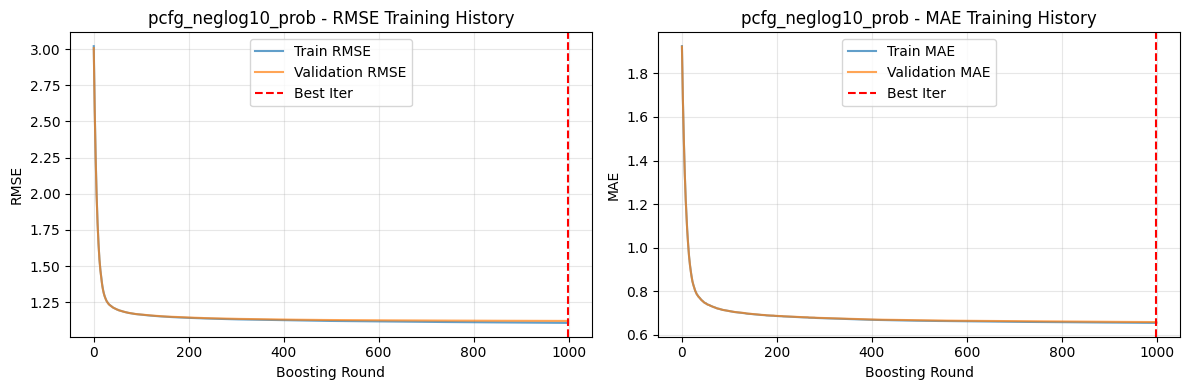

In [16]:
def train_xgboost_regression(dtrain, dval, target_name):
    """
    Train XGBoost regression model on CPU with early stopping
    """
    print("\n" + "=" * 60)
    print("TRAINING XGBOOST REGRESSION MODEL (CPU)")
    print("=" * 60)
    
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': ['rmse', 'mae'],
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'gamma': 0,
        'seed': 42,
        'tree_method': 'hist',  # CPU-only
        'device': 'cpu'         # Force CPU
    }
    
    print("\nTraining Parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    evals_result = {}
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dtrain, 'train'), (dval, 'validation')],
        early_stopping_rounds=50,
        evals_result=evals_result,
        verbose_eval=50
    )
    
    print(f"\nTraining stopped at round {model.best_iteration}")
    print(f"Best validation score: {model.best_score:.6f}")
    
    # Plot RMSE and MAE
    if len(evals_result['validation']['rmse']) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # RMSE
        axes[0].plot(evals_result['train']['rmse'], label='Train RMSE', alpha=0.7)
        axes[0].plot(evals_result['validation']['rmse'], label='Validation RMSE', alpha=0.7)
        axes[0].axvline(x=model.best_iteration, color='r', linestyle='--', label=f'Best Iter')
        axes[0].set_xlabel('Boosting Round')
        axes[0].set_ylabel('RMSE')
        axes[0].set_title(f'{target_name} - RMSE Training History')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        # MAE
        axes[1].plot(evals_result['train']['mae'], label='Train MAE', alpha=0.7)
        axes[1].plot(evals_result['validation']['mae'], label='Validation MAE', alpha=0.7)
        axes[1].axvline(x=model.best_iteration, color='r', linestyle='--', label=f'Best Iter')
        axes[1].set_xlabel('Boosting Round')
        axes[1].set_ylabel('MAE')
        axes[1].set_title(f'{target_name} - MAE Training History')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('xgboost_training_history.png', dpi=100, bbox_inches='tight')
        plt.show()
    
    return model, params

# Train model
model, params = train_xgboost_regression(dtrain, dval, target_col)


Model Evaluation & Prediction


MODEL EVALUATION ON TEST SET

Test Set Performance Metrics:
  MSE:  1.255565
  RMSE: 1.120520
  MAE:  0.658994
  R²:   0.883196

Example Predictions (first 10):
      Actual  Predicted     Error
0  10.143871   9.678534  0.465337
1  13.098722  12.621970  0.476752
2  12.923680  11.029094  1.894586
3   9.471411   9.094542  0.376870
4   9.115936   9.474842 -0.358906
5  11.522059  11.125375  0.396684
6  11.810172  10.661531  1.148641
7   7.941182   8.843090 -0.901908
8   7.403611   7.412285 -0.008675
9   7.485324   7.470798  0.014526


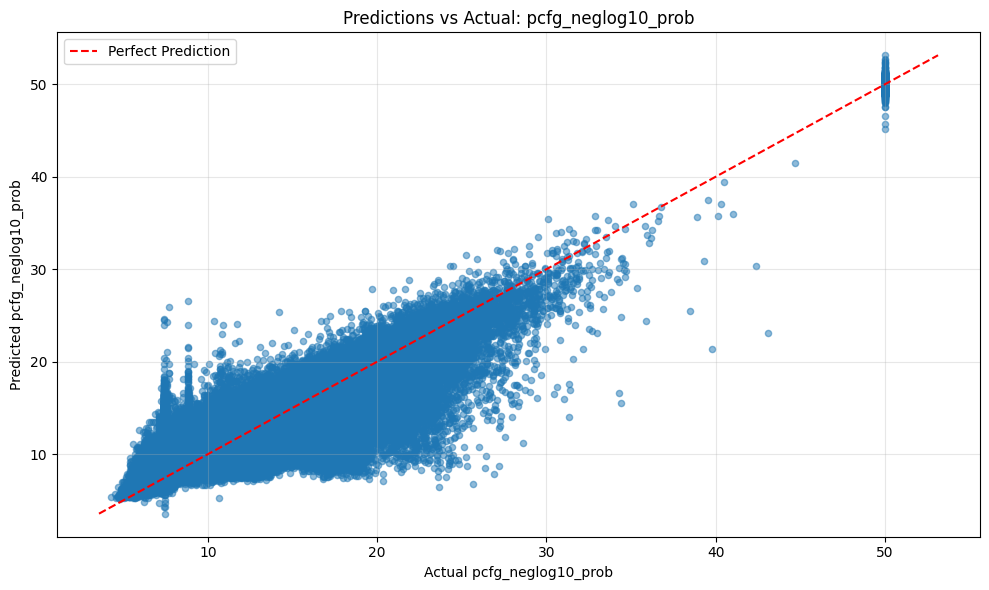

In [17]:
def evaluate_model(model, dtest, y_test, target_name):
    print("\n" + "=" * 60)
    print("MODEL EVALUATION ON TEST SET")
    print("=" * 60)
    
    y_pred = model.predict(dtest)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nTest Set Performance Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    # Example predictions
    examples = pd.DataFrame({
        'Actual': y_test.values[:10],
        'Predicted': y_pred[:10],
        'Error': y_test.values[:10] - y_pred[:10]
    })
    print("\nExample Predictions (first 10):")
    print(examples.to_string())
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, s=20)
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.title(f'Predictions vs Actual: {target_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('predictions_vs_actual.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    return y_pred, {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate
y_pred, metrics = evaluate_model(model, dtest, y_test, target_col)

Feature importance 


FEATURE IMPORTANCE ANALYSIS

Top 20 most important features:
                       feature  importance
                    omen_log10      6769.0
          zxcvbn_log10_guesses      6515.0
     dictionary_coverage_ratio      5455.0
longest_dictionary_word_length      3464.0
     combined_entropy_pca_norm      3228.0
                     num_lower      3205.0
   transitions_to_length_ratio      3004.0
                        length      2710.0
                 letter_spread      2699.0
                bigram_entropy      2227.0
       length_adjusted_entropy      2225.0
                     num_upper      2079.0
                  digit_spread      1787.0
                    num_digits      1758.0
     alternating_pattern_score      1360.0
   num_consecutive_letter_runs      1232.0
      longest_same_char_streak      1057.0
              num_special_char       975.0
     digit_letter_mixing_score       953.0
          contains_common_name       948.0


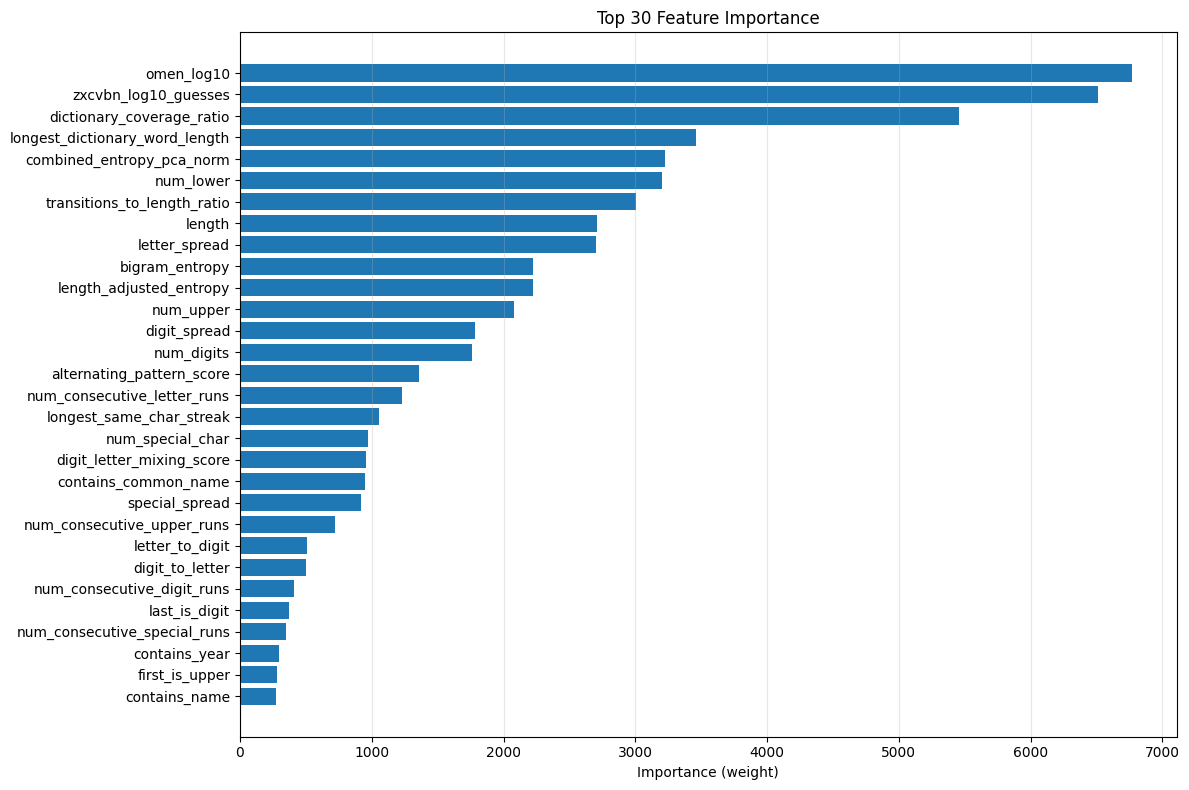

In [19]:
def analyze_feature_importance(model, features):
    """
    Analyze and visualize feature importance
    """
    print("\n" + "=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # Get feature importance
    importance_dict = model.get_score(importance_type='weight')
    
    if not importance_dict:
        print("No feature importance scores available")
        return
    
    # Convert to DataFrame
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 20 most important features:")
    print(importance_df.head(20).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    
    # Plot top 30 features
    top_n = min(30, len(importance_df))
    top_features = importance_df.head(top_n)
    
    plt.barh(range(top_n), top_features['importance'].values)
    plt.yticks(range(top_n), top_features['feature'].values)
    plt.xlabel('Importance (weight)')
    plt.title(f'Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()  # Most important on top
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    return importance_df

# Analyze features
importance_df = analyze_feature_importance(model, features)


In [ ]:
def save_model_and_results(model, params, metrics, importance_df, target_col, y_test, y_pred):
    print("\n" + "=" * 60)
    print("SAVING MODEL AND RESULTS")
    print("=" * 60)
    
    model.save_model(f'final_model.json')
    
    pd.DataFrame(list(params.items()), columns=['Parameter', 'Value']).to_csv(
        f'model_params.csv', index=False
    )
    
    pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value']).to_csv(
        f'model_metrics.csv', index=False
    )
    
    if importance_df is not None:
        importance_df.to_csv(f'model_feature_importance.csv', index=False)
    
    pd.DataFrame({
        'actual': y_test.values,
        'predicted': y_pred,
        'error': y_test.values - y_pred
    }).to_csv(f'model_predictions.csv', index=False)
    
    print(f"All files saved with prefix 'model_'")

save_model_and_results(model, params, metrics, importance_df, target_col, y_test, y_pred)

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Target: {target_col}")
print(f"Final test R²: {metrics['r2']:.4f}")
print("Check the generated PNG files for visualizations")



SAVING MODEL AND RESULTS
All files saved with prefix 'model_'

TRAINING COMPLETE!
Target: pcfg_neglog10_prob
Final test R²: 0.8832
Check the generated PNG files for visualizations
